In [1]:
import os
import sys
#set custom path
sys.path.insert(0, os.path.abspath(r'\users\fynn\documents\anaconda\envs\tf_keras_gpu_test\lib\site-packages'))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)
        
#gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333) 
#sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True, gpu_options=gpu_options))

1 Physical GPUs, 1 Logical GPUs


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

from copy import deepcopy as dc


from PIL import Image
import requests
from io import BytesIO

%run data_functions.py

## Import Images

In [3]:
from torchvision import datasets, transforms
import torch

data_dir = '../image_dir'


tc = transforms.Compose([

        transforms.Resize((160, 240)),

        transforms.ToTensor()              

    ])

image_datasets = datasets.ImageFolder(data_dir, transform = tc)
dloader = torch.utils.data.DataLoader(image_datasets, batch_size=10, shuffle=False)
print(len(image_datasets)) #number of datapoints

4784


torch.Size([160, 240, 3])
tensor([[[0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7216, 0.7216],
         [0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7216, 0.7216],
         [0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7255, 0.7216],
         ...,
         [0.3333, 0.3961, 0.4431,  ..., 0.6745, 0.6745, 0.6706],
         [0.3843, 0.4196, 0.4471,  ..., 0.6745, 0.6706, 0.6706],
         [0.4784, 0.4510, 0.4196,  ..., 0.6745, 0.6706, 0.6706]],

        [[0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7216, 0.7216],
         [0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7216, 0.7216],
         [0.7216, 0.7216, 0.7255,  ..., 0.7255, 0.7255, 0.7216],
         ...,
         [0.2431, 0.3059, 0.3490,  ..., 0.6471, 0.6471, 0.6431],
         [0.2863, 0.3216, 0.3490,  ..., 0.6471, 0.6431, 0.6431],
         [0.3804, 0.3529, 0.3216,  ..., 0.6471, 0.6431, 0.6431]],

        [[0.6745, 0.6745, 0.6784,  ..., 0.6784, 0.6745, 0.6745],
         [0.6745, 0.6745, 0.6784,  ..., 0.6784, 0.6745, 0.6745],
         [0.6745, 0.6745, 0.6784

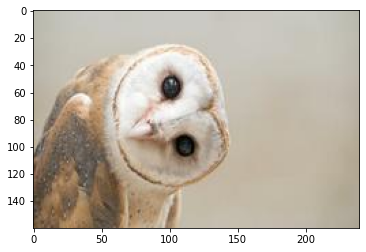

In [4]:
for img, label in dloader:

    print(np.transpose(img[0], (1,2,0)).shape)

    print(img[0])

    plt.imshow((img[0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))

    plt.show()


    break

## ResNet Embedding

Uses [this tutorial](https://www.activeloop.ai/resources/1E3oKP83o4KXIFChCesv7r/generate-image-embeddings-using-a-pre-trained-cnn-and-store-them-in-hub/)

In [5]:
# fetch pretrained model

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

Using cache found in C:\Users\fynn/.cache\torch\hub\pytorch_vision_v0.10.0


In [6]:
# Select the desired layer, one before it classifies
layer = model._modules.get('avgpool')

#use register_forward_hook module to get embeddings
def copy_embeddings(m, i, o):

    """Copy embeddings from the penultimate layer.

    """

    o = o[:, :, 0, 0].detach().numpy().tolist()

    outputs.append(o)

outputs = []

# attach hook to the penulimate layer
_ = layer.register_forward_hook(copy_embeddings)


In [7]:
model.eval() # Inference mode

# Generate image embeddings for all images in dloader and save them in the list outputs
for X, y in dloader:
    _ = model(X)

print(len(outputs)) 

479


In [8]:
# flatten list of embeddings to remove batches
list_embeddings = [item for sublist in outputs for item in sublist]

print(len(list_embeddings)) # should return same length as dloader
print(np.array(list_embeddings[0]).shape) #returns (512,)

4784
(512,)


In [9]:
list_embeddings[0][:10]

[2.9375505447387695,
 0.8822081685066223,
 0.3535681664943695,
 2.2382137775421143,
 2.3100383281707764,
 0.5889728665351868,
 0.2790653705596924,
 0.29174622893333435,
 0.6368246078491211,
 3.11283802986145]

Next steps:
- Evaluation of clustering using neighbours v. labels
- Testing dataset
    - Embedding unknown image inputs with the above workflow?
- Improving recommendation:
    - input images
    - clustering model/distance metric
    - [Stretch]: train embedding
- [Saving/exporting embeddings? Saving 'versions'?]

# Clustering - nearest neighbor

In [10]:
from tqdm import tqdm

num_clusters = 12  # Number of clusters.
k_neighbours = 7 # Number of neighbours to consider during cluster learning.
tune_encoder_during_clustering = False  # Freeze the encoder in the cluster learning.

In [11]:
neighbours = []
batch_size = 500
num_batches = len(list_embeddings) // batch_size
for batch_idx in tqdm(range(num_batches)):
    start_idx = batch_idx * batch_size
    end_idx = start_idx + batch_size
    current_batch = list_embeddings[start_idx:end_idx]
    # Compute the dot similarity.
    similarities = tf.linalg.matmul(current_batch, list_embeddings, transpose_b=True)
    #print(similarities)
    # Get the indices of most similar vectors.
    _, indices = tf.math.top_k(similarities, k=k_neighbours + 1, sorted=True)
    
    
    # Add the indices to the neighbours.
    neighbours.append(indices[..., 1:])

neighbours = np.reshape(np.array(neighbours), (-1, k_neighbours))


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:05<00:00,  1.74it/s]


In [12]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [13]:
len(similarities[0]), len(set(similarities[0].tolist()))

(4784, 4780)

200
203
3579
2500
3400


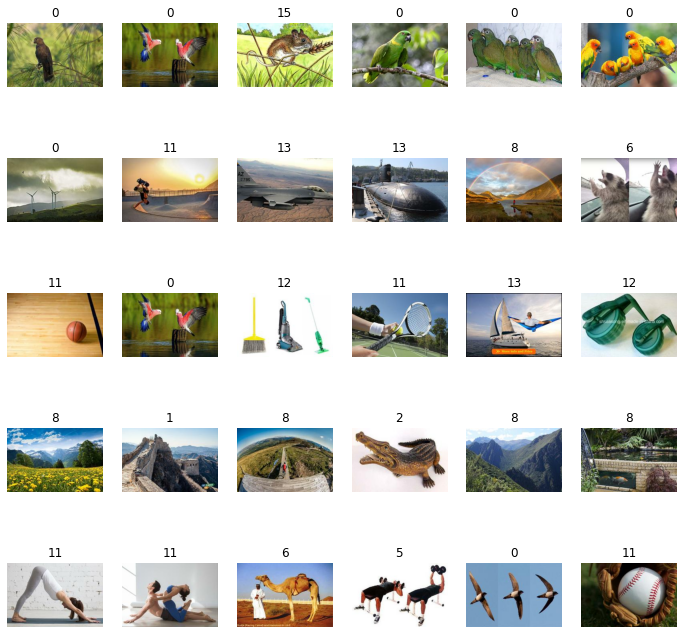

In [30]:
nrows = 5
ncols = 6
compare_idx = [200, 203, 3579, 2500, 3400, 4230]

plt.figure(figsize=(12, 12))
position = 1
for i in range(nrows):
    anchor_idx = compare_idx[i]
    #anchor_idx = np.random.choice(range(len(neighbours)))
    print(anchor_idx)
    
    #only take unique neighbours
    unique_neighbours = []
    for neighbour in neighbours[anchor_idx]:
        if neighbour != anchor_idx:
            unique_neighbours.append(neighbour)
    
    indices = [anchor_idx] + unique_neighbours
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        try:
            plt.imshow((image_datasets[indices[j]][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
            plt.title(image_datasets[indices[j]][1])      
        except:
            pass
        plt.axis("off")
        position += 1


# Testing

## Single Image

In [15]:
im = Image.open("../test_dir/test_22.jpeg")
convert_tensor = transforms.ToTensor()
tensor_im = convert_tensor(im)
print(tensor_im.shape)

plt.imshow(im)

FileNotFoundError: [Errno 2] No such file or directory: '../test_dir/test_22.jpeg'

In [ ]:
tensor_im = tensor_im.reshape((1, 3, 160, 240))

In [ ]:
test_embedding = model(tensor_im)

# Clustering - DBSCAN

Has a bad time

In [ ]:
import hdbscan

clusterer = hdbscan.HDBSCAN()

clusterer.fit(list_embeddings)

In [ ]:
labels = clusterer.labels_

print(np.count_nonzero(labels != -1))
clusterer.labels_.max()

In [ ]:
np.where(clusterer.labels_ == clusterer.labels_[1200])[0]

In [ ]:
plt.figure(figsize=(12, 12))
position = 1
for i in range(nrows):
    
    anchor_idx = compare_idx[i]
    neighbor_indicies = np.where(clusterer.labels_ == clusterer.labels_[anchor_idx])[0]
    indices = [anchor_idx] + neighbour_indicies.tolist()
    
    for j in range(ncols):
        plt.subplot(nrows, ncols, position)
        plt.imshow((image_datasets[indices[j]][0].detach().numpy().transpose(1, 2, 0)*255).astype(np.uint8))
        plt.title(image_datasets[indices[j]][1])
        plt.axis("off")
        position += 1


In [ ]:
clusterer.probabilities_